In [1]:
import pyMSB as ms
import matplotlib.pyplot as plt
import numpy as np

# Model Comparison

Comparing 3 different physical models using PyMC log likelihood. Based on an [example](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/model_comparison.html) on the official PyMC website.

### Spectrum genaration

True spectrum contains a sextet and a small singlet.

In [5]:
# Define spectroscope parameters
CHANNELS = np.arange(0, 1024, dtype=int)
GEOMETRY = ms.models.SpectroscopeGeometry.TRANSMISSION
spectroscope_true = ms.models.SpectroscopeComputable(scale=40, isomer_shift_ref=512)

In [23]:
# Define subspectra
singlet_true = ms.models.SingletComputable(amplitude=2e3,
                                           isomer_shift=0,
                                           line_width1=8)
sextet_true = ms.models.SextetComputable(amplitude=1e4,
                                         isomer_shift=0,
                                         quadrupole_split=20,
                                         ratio13=3,
                                         ratio23=2,
                                         magnetic_field=30,
                                         line_width1=8,
                                         line_width2=8,
                                         line_width3=8,
                                         line_width4=8,
                                         line_width5=8,
                                         line_width6=8,
                                         line_width7=8,
                                         line_width8=8)

# Define spectrum
spectrum_true = ms.models.SpectrumComputable(background=1e5,
                                             singlets=[singlet_true],
                                             sextets=[sextet_true]
                                             )

In [24]:
# Compute true spectrum values
spectrum_true_values = ms.spectrum_func(CHANNELS, spectrum_true, spectroscope_true, GEOMETRY)

# Sample spectrum counts
sprectrum_sample = ms.generate_spectrum(CHANNELS, spectrum_true, spectroscope_true, GEOMETRY)

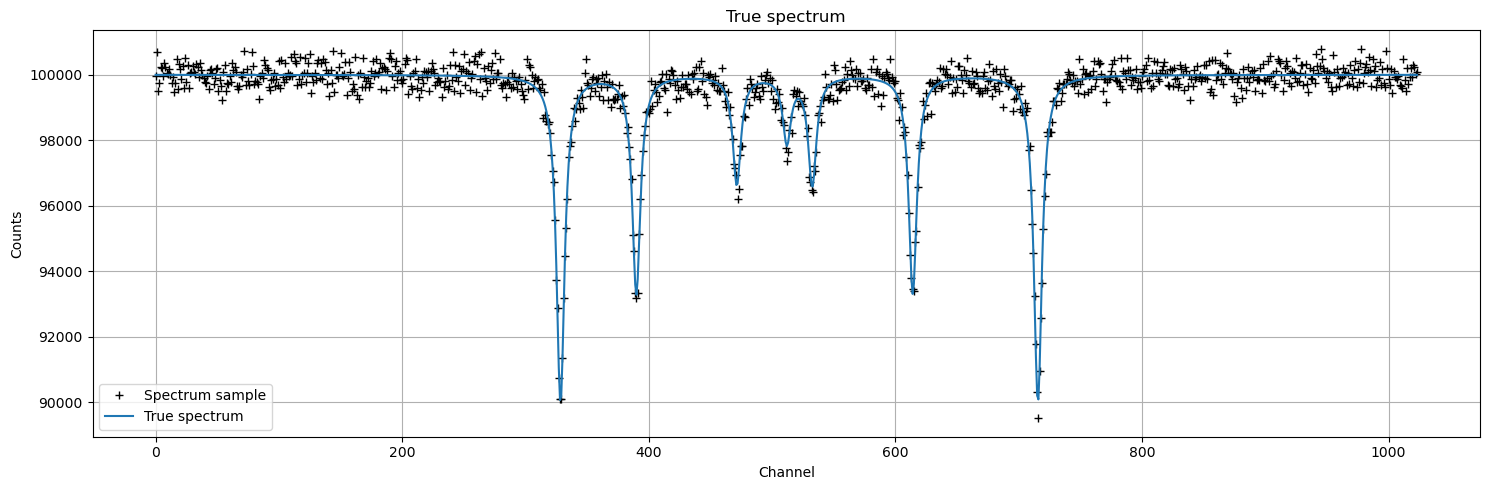

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

ax.plot(CHANNELS, sprectrum_sample, 'k+', label='Spectrum sample')
ax.plot(CHANNELS, spectrum_true_values, label='True spectrum')
ax.legend()
ax.grid()
plt.xlabel('Channel')
plt.ylabel('Counts')
plt.title('True spectrum')
plt.tight_layout()

### Fitting models definition

3 models are defined for comparison:
 - Only one sextet (underfitting)
 - Singlet and sextet (optimal model)
 - Singlet, doublet, and sextet (overfitting)

In [55]:
# Define subspectra specs (user estimate)

singlet_specs = ms.models.SingletSpecs(amplitude=ms.models.SpecsVar(value=2e3),
                                       isomer_shift=ms.models.SpecsVar(value=0),
                                       line_width1=ms.models.SpecsVar(value=8)
                                       )
doublet_specs = ms.models.DoubletSpecs(amplitude=ms.models.SpecsVar(value=1e3),
                                    isomer_shift=ms.models.SpecsVar(value=-10),
                                    quadrupole_split=ms.models.SpecsVar(value=60),
                                    line_width1=ms.models.SpecsVar(value=8),
                                    line_width2=ms.models.SpecsVar(value=8),
                                    line_width_coupling=ms.models.LineWidthCoupling.COUPLED
                                    )
sextet_specs = ms.models.SextetSpecs(amplitude=ms.models.SpecsVar(value=1e4),
                                    isomer_shift=ms.models.SpecsVar(value=0),
                                    quadrupole_split=ms.models.SpecsVar(value=20),
                                    ratio13=ms.models.SpecsVar(value=3, is_fixed=True),
                                    ratio23=ms.models.SpecsVar(value=2, is_fixed=True),
                                    magnetic_field=ms.models.SpecsVar(value=30),
                                    line_width1=ms.models.SpecsVar(value=8),
                                    line_width2=ms.models.SpecsVar(value=8),
                                    line_width3=ms.models.SpecsVar(value=8),
                                    line_width4=ms.models.SpecsVar(value=8),
                                    line_width5=ms.models.SpecsVar(value=8),
                                    line_width6=ms.models.SpecsVar(value=8),
                                    line_width7=ms.models.SpecsVar(value=8),
                                    line_width8=ms.models.SpecsVar(value=8),
                                    line_width_coupling=ms.models.LineWidthCoupling.COUPLED
                                    )


# Define spectrum specs (user estimate)

spectrum_specs_sx = ms.models.SpectrumSpecs(background=ms.models.SpecsVar(value=1e5 + 110),
                                         sextets=[sextet_specs])

spectrum_specs_sg_sx = ms.models.SpectrumSpecs(background=ms.models.SpecsVar(value=1e5 + 110),
                                         singlets=[singlet_specs],
                                         sextets=[sextet_specs])

spectrum_specs_sg_db_sx = ms.models.SpectrumSpecs(background=ms.models.SpecsVar(value=1e5 + 110),
                                         singlets=[singlet_specs],
                                         doublets=[doublet_specs],   
                                         sextets=[sextet_specs])

# Define analysis specs (user estimate)
analysis_specs_sx = ms.models.AnalysisSpecs(spectrum=spectrum_specs_sx, scope=spectroscope_true)
analysis_specs_sg_sx = ms.models.AnalysisSpecs(spectrum=spectrum_specs_sg_sx, scope=spectroscope_true)
analysis_specs_sg_db_sx = ms.models.AnalysisSpecs(spectrum=spectrum_specs_sg_db_sx, scope=spectroscope_true)

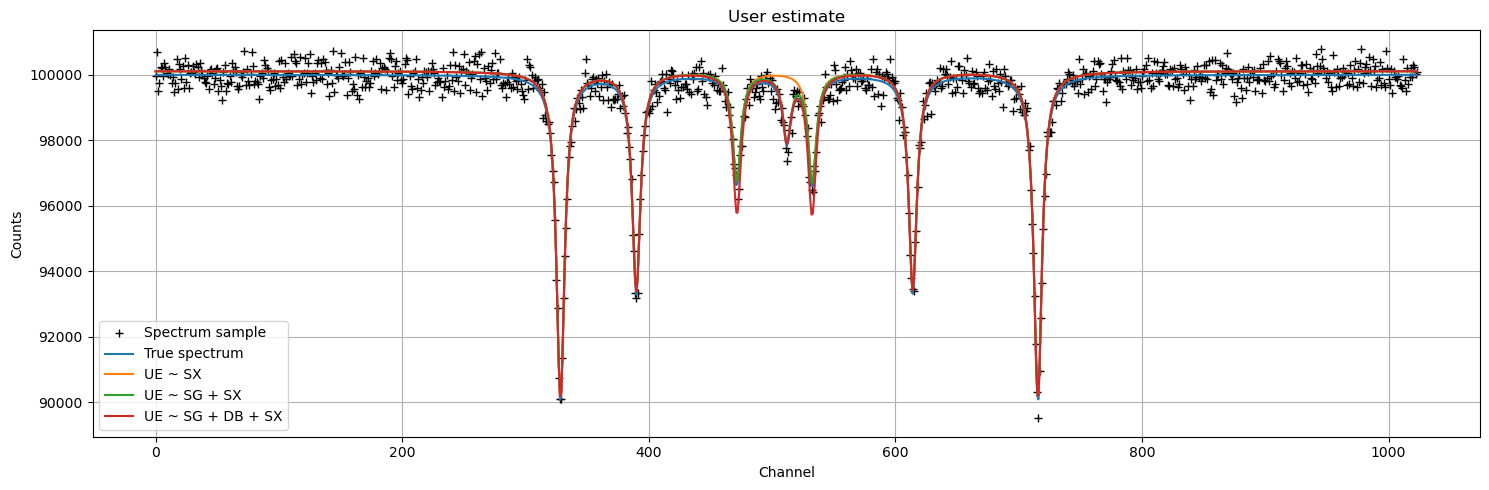

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

ax.plot(CHANNELS, sprectrum_sample, 'k+', label='Spectrum sample')
ax.plot(CHANNELS, spectrum_true_values, label='True spectrum')
ax.plot(CHANNELS, ms.spectrum_func(CHANNELS, spectrum_specs_sx.map(lambda x: x.value), spectroscope_true, GEOMETRY), label='UE ~ SX')
ax.plot(CHANNELS, ms.spectrum_func(CHANNELS, spectrum_specs_sg_sx.map(lambda x: x.value), spectroscope_true, GEOMETRY), label='UE ~ SG + SX')
ax.plot(CHANNELS, ms.spectrum_func(CHANNELS, spectrum_specs_sg_db_sx.map(lambda x: x.value), spectroscope_true, GEOMETRY), label='UE ~ SG + DB + SX')
ax.legend()
ax.grid()
plt.xlabel('Channel')
plt.ylabel('Counts')
plt.title('User estimate')
plt.tight_layout()

### Fit FullBayes

In [57]:
# Define analysis model
bayes_model_sx = ms.BayesianModel(analysis_specs_sx, GEOMETRY)
bayes_model_sg_sx = ms.BayesianModel(analysis_specs_sg_sx, GEOMETRY)
bayes_model_sg_db_sx = ms.BayesianModel(analysis_specs_sg_db_sx, GEOMETRY)

In [58]:
# Fit Bayes model to sample spectrum
bayes_model_sx = bayes_model_sx.fit(CHANNELS, sprectrum_sample)
bayes_model_sg_sx = bayes_model_sg_sx.fit(CHANNELS, sprectrum_sample)
bayes_model_sg_db_sx = bayes_model_sg_db_sx.fit(CHANNELS, sprectrum_sample)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [bckg_coeff, sx0_amplitude_coeff, sx0_isomer_shift, sx0_quadrupole_split, sx0_magnetic_field, sx0_line_width123456]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 7 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [bckg_coeff, sg0_amplitude_coeff, sg0_isomer_shift, sg0_line_width, sx0_amplitude_coeff, sx0_isomer_shift, sx0_quadrupole_split, sx0_magnetic_field, sx0_line_width123456]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 11 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [bckg_coeff, sg0_amplitude_coeff, sg0_isomer_shift, sg0_line_width, db0_amplitude_coeff, db0_isomer_shift, db0_quadrupole_split, db0_line_width12, sx0_amplitude_coeff, sx0_isomer_shift, sx0_quadrupole_split, sx0_magnetic_field, sx0_line_width123456]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 43 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


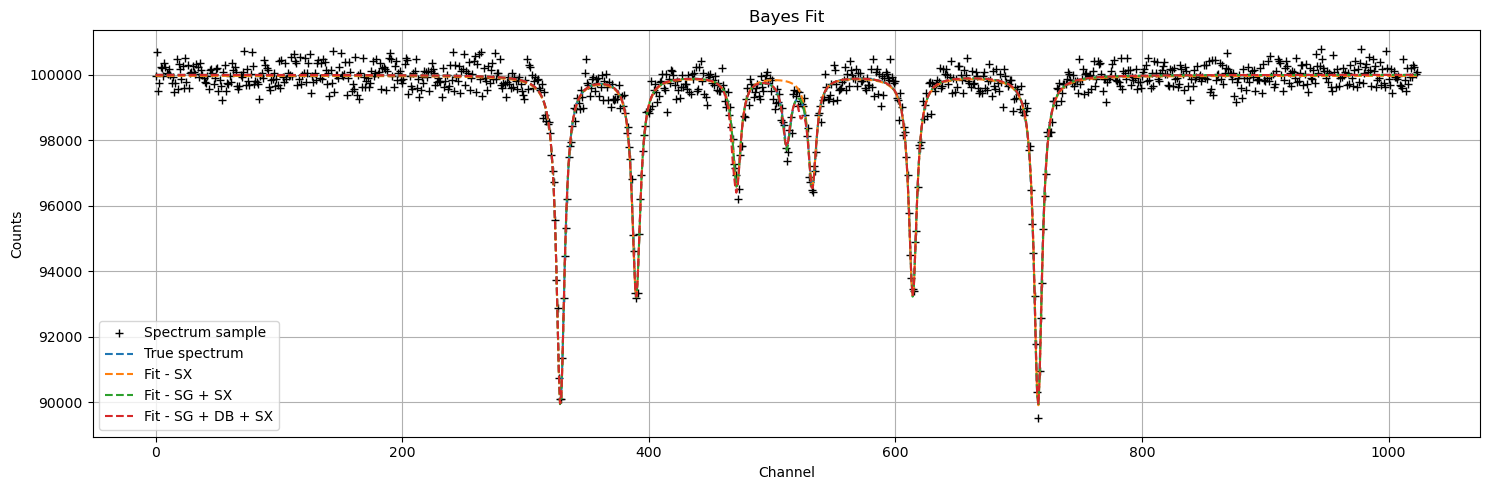

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

ax.plot(CHANNELS, sprectrum_sample, 'k+', label='Spectrum sample')
ax.plot(CHANNELS, spectrum_true_values, '--', label='True spectrum')
ax.plot(CHANNELS, bayes_model_sx.predict(CHANNELS), '--', label='Fit - SX')
ax.plot(CHANNELS, bayes_model_sg_sx.predict(CHANNELS), '--', label='Fit - SG + SX')
ax.plot(CHANNELS, bayes_model_sg_db_sx.predict(CHANNELS), '--', label='Fit - SG + DB + SX')
ax.legend()
ax.grid()
plt.xlabel('Channel')
plt.ylabel('Counts')
plt.title('Bayes Fit')
plt.tight_layout()

### Model Comparison

In [33]:
import pymc as pm
import arviz as az

In [60]:
with bayes_model_sx.model:
    pm.compute_log_likelihood(bayes_model_sx.idata)

with bayes_model_sg_sx.model:
    pm.compute_log_likelihood(bayes_model_sg_sx.idata)

with bayes_model_sg_db_sx.model:
    pm.compute_log_likelihood(bayes_model_sg_db_sx.idata)

In [61]:
model_comparison = az.compare({"SX": bayes_model_sx.idata, "SG + SX": bayes_model_sg_sx.idata, "SG + DB + SX": bayes_model_sg_db_sx.idata}, ic="loo", scale="log")
model_comparison

c:\Users\vojtech.skoumal\.conda\envs\pyMSB\Lib\site-packages\arviz\stats\stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.67 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
SG + SX,0,-7338.641147,7.459969,0.000000,1.000000e+00,20.253034,0.000000,False,log
SG + DB + SX,1,-7341.532771,16.025123,2.891624,0.000000e+00,20.155644,2.198527,True,log
SX,2,-7473.682481,5.063924,135.041333,6.663781e-12,51.353377,46.684621,False,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

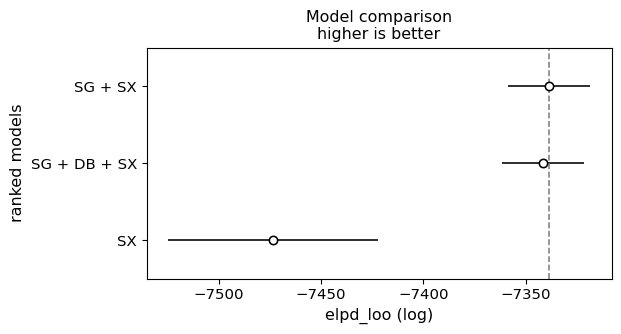

In [62]:
az.plot_compare(model_comparison, insample_dev=False)

In [66]:
bayes_model_sg_db_sx.results.spectrum.doublets[0].amplitude.value.mean()

597.9701746593113

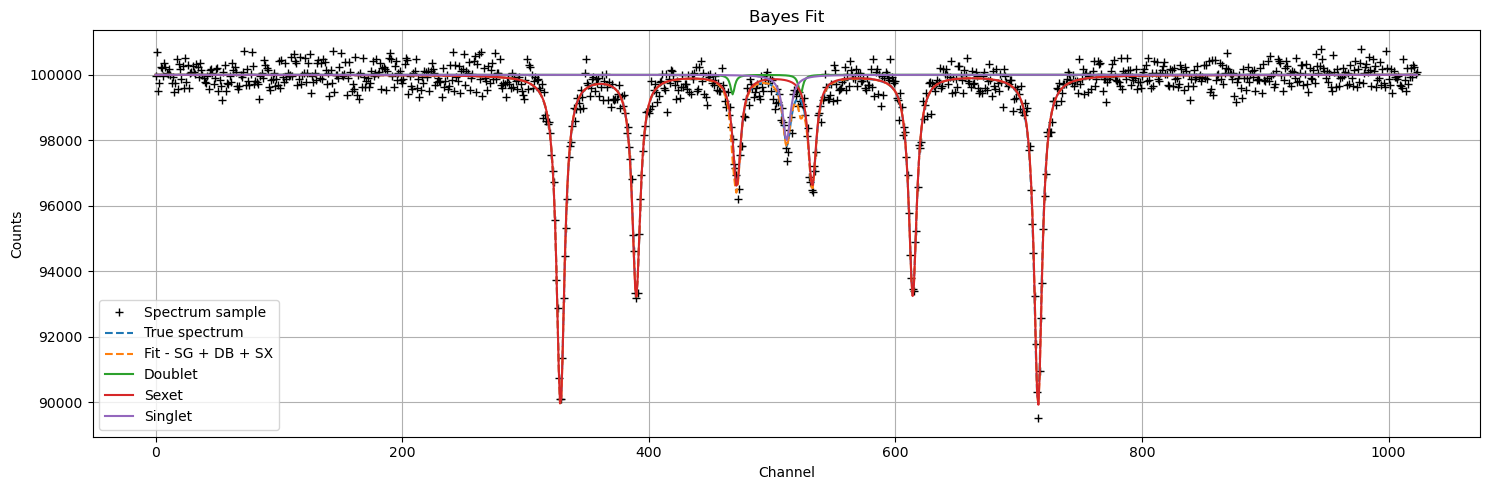

In [67]:
import copy

fig, ax = plt.subplots(1, 1, figsize=(15, 5))

ax.plot(CHANNELS, sprectrum_sample, 'k+', label='Spectrum sample')
ax.plot(CHANNELS, spectrum_true_values, '--', label='True spectrum')
ax.plot(CHANNELS, bayes_model_sg_db_sx.predict(CHANNELS), '--', label='Fit - SG + DB + SX')

t_spectrum = copy.deepcopy(bayes_model_sg_db_sx.results.spectrum)
t_spectrum.singlets = []
t_spectrum.sextets = []
plt.plot(CHANNELS, ms.spectrum_func(CHANNELS, t_spectrum.map(lambda x: x.value.mean()), spectroscope_true, GEOMETRY), label='Doublet')

t_spectrum = copy.deepcopy(bayes_model_sg_db_sx.results.spectrum)
t_spectrum.singlets = []
t_spectrum.doublets = []
plt.plot(CHANNELS, ms.spectrum_func(CHANNELS, t_spectrum.map(lambda x: x.value.mean()), spectroscope_true, GEOMETRY), label='Sexet')

t_spectrum = copy.deepcopy(bayes_model_sg_db_sx.results.spectrum)
t_spectrum.sextets = []
t_spectrum.doublets = []
plt.plot(CHANNELS, ms.spectrum_func(CHANNELS, t_spectrum.map(lambda x: x.value.mean()), spectroscope_true, GEOMETRY), label='Singlet')


ax.legend()
ax.grid()
plt.xlabel('Channel')
plt.ylabel('Counts')
plt.title('Bayes Fit')
plt.tight_layout()